<a href="https://colab.research.google.com/github/JUCSERahull337/Task_Assessment/blob/master/Job_Assessment_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Dataset
├── Train
│   ├── infected
│   └── not infected
└── Test
    ├── infected
    └── not infected

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


In [ ]:
!pip install torch torchvision diffusers albumentations


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Assuming infected images are labeled as 1 and not infected as 0
        for class_name in ["intected", "notinfected"]:
            class_dir = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_dir):
                if image_name.endswith(".jpg"):  # Or your image file extension
                    self.image_paths.append(os.path.join(class_dir, image_name))
                    self.labels.append(1 if class_name == "intected" else 0)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        # Return the image and label as a tuple, but with the label as a tensor
        return image, torch.tensor(label)

In [ ]:
# Data Augmentation and Normalization
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Train and Test Datasets
train_dataset = ImageDataset("/content/drive/MyDrive/Dataset For PCOS/Data/train", transform=transform)
test_dataset = ImageDataset("/content/drive/MyDrive/Dataset For PCOS/Data/test", transform=transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Dataset For PCOS/Data/train/intected'

In [ ]:
# Convert paths to datasets
class ImageDataset(Dataset):
    def __init__(self, image_paths, prompts, transform=None):
        self.image_paths = image_paths
        self.prompts = prompts
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = 1 if self.prompts[idx] == "infected" else 0

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

# Now, use the paths and prompts you've collected
train_dataset = ImageDataset(train_images, train_prompts, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


In [ ]:
import os
from glob import glob

# Set paths to your training folders
train_infected_path = "/content/drive/MyDrive/Dataset For PCOS/Data/train/intected"
train_not_infected_path = "/content/drive/MyDrive/Dataset For PCOS/Data/train/notinfected/"

# Collect all image paths and assign prompts
train_images = glob(os.path.join(train_infected_path, "*.jpg")) + glob(os.path.join(train_not_infected_path, "*.jpg"))
train_prompts = ["infected"] * len(glob(os.path.join(train_infected_path, "*.jpg"))) + ["not infected"] * len(glob(os.path.join(train_not_infected_path, "*.jpg")))

# Shuffle the data to mix infected and not infected
import random
combined = list(zip(train_images, train_prompts))
random.shuffle(combined)
train_images, train_prompts = zip(*combined)

# Confirm the data
print(f"Number of training images: {len(train_images)}")
print(f"Example image path: {train_images[0]}")
print(f"Example prompt: {train_prompts[0]}")


Number of training images: 1143
Example image path: /content/drive/MyDrive/Dataset For PCOS/Data/train/notinfected/notinfected (724).jpg
Example prompt: not infected


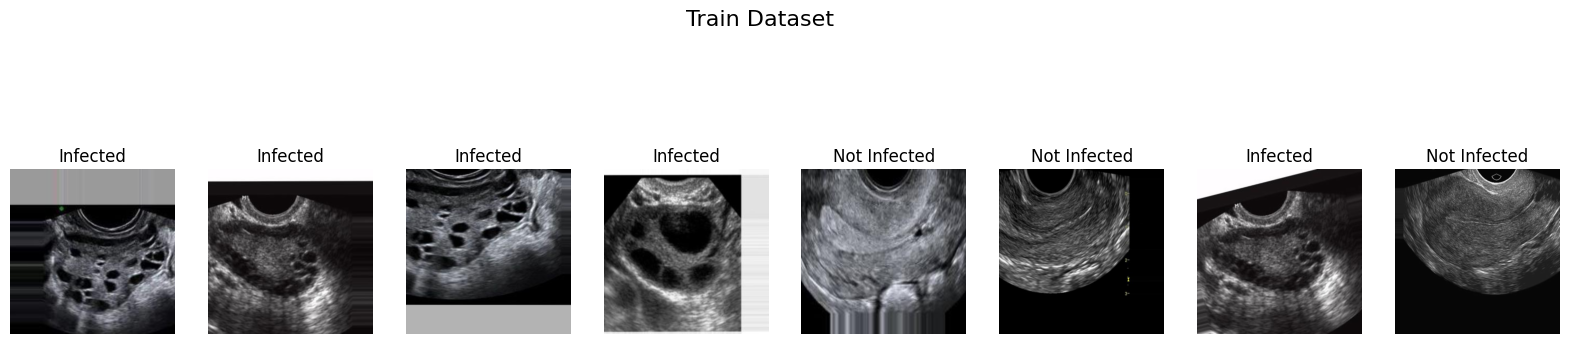

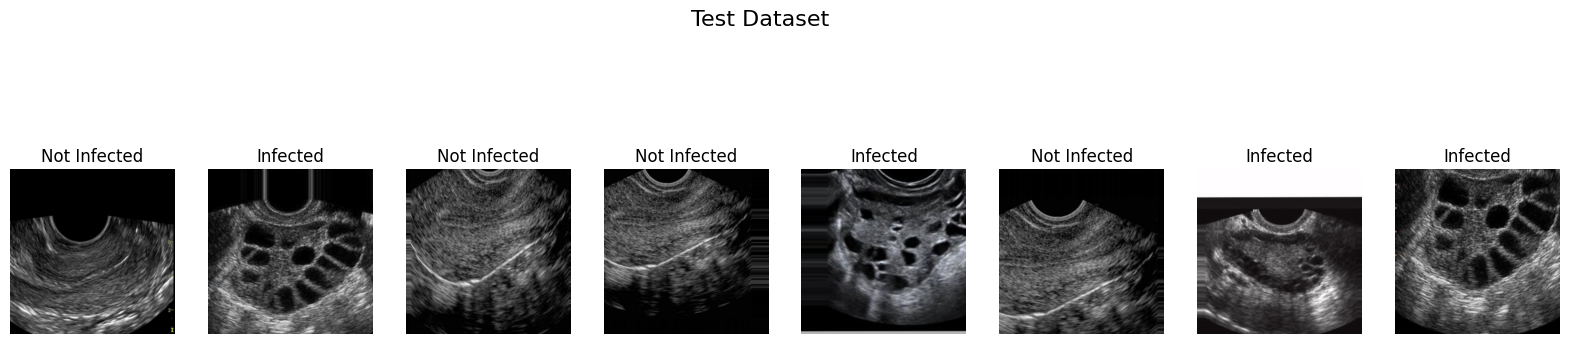

In [ ]:
import matplotlib.pyplot as plt
import random

def visualize_dataset(dataset, num_images=8, title="Dataset Visualization"):
    """
    Visualizes random images from the dataset.
    """
    # Select random indices
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = (image * 0.5 + 0.5).permute(1, 2, 0).numpy()  # Unnormalize and convert to NumPy
        axes[i].imshow(image)
        axes[i].set_title("Infected" if label == 1 else "Not Infected")
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize Train Dataset
visualize_dataset(train_dataset, num_images=8, title="Train Dataset")

# Visualize Test Dataset
visualize_dataset(test_dataset, num_images=8, title="Test Dataset")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define a simple CNN architecture
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 64 * 64, 512)  # Fully connected layer
        self.fc2 = nn.Linear(512, 2)  # Binary output: infected or not infected
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pass through convolutional layers and apply ReLU activation
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        # Flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        # Output probabilities for binary classification
        return self.softmax(x)

# Initialize the model
model = SimpleCNN().to("cuda")


In [ ]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Inside training loop
    scheduler.step()

    for images, labels in train_loader:
        # Ensure both images and labels are moved to GPU
        images = images.to("cuda")

        # Convert labels to numerical representation (0 for 'not infected', 1 for 'infected')
        labels = torch.tensor([1 if label == 'infected' else 0 for label in labels]).to("cuda")

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader)}")

Epoch [1/5], Loss: 0.3439293946656916
Epoch [2/5], Loss: 0.3133033269809352
Epoch [3/5], Loss: 0.3132963900764783
Epoch [4/5], Loss: 0.31329439621832633
Epoch [5/5], Loss: 0.3132928746442


In [ ]:
# Evaluate the model on the test dataset
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in test_loader:
        images, labels = images.to("cuda"), labels.to("cuda")

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


Test Accuracy: 59.40748440748441%


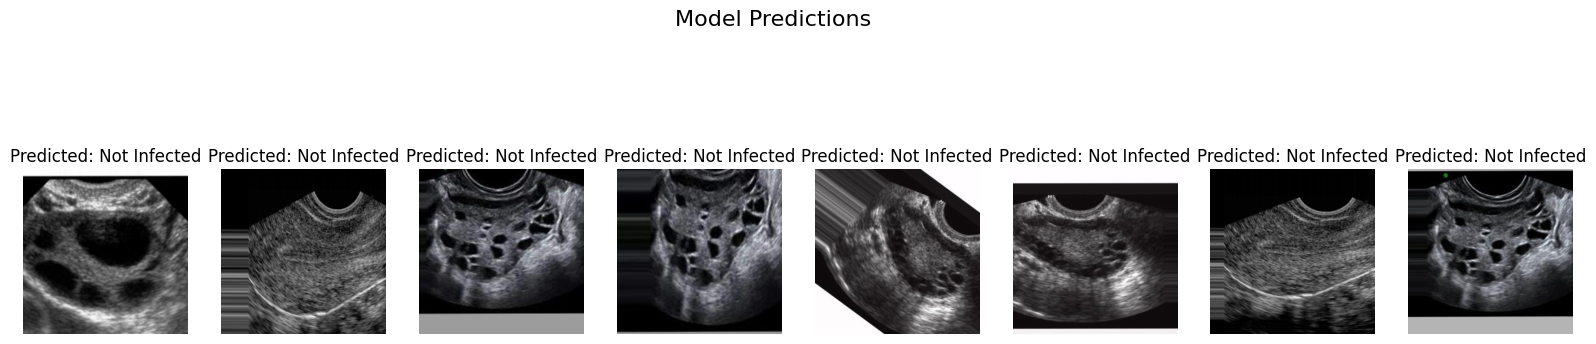

In [ ]:
# Visualize predictions
def visualize_predictions(model, dataset, num_images=8, title="Model Predictions"):
    """
    Visualizes random images from the dataset with predicted labels.
    """
    indices = random.sample(range(len(dataset)), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    model.eval()

    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        image = image.unsqueeze(0).to("cuda")  # Add batch dimension and move to GPU

        # Get model prediction
        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)

        image = (image.squeeze(0) * 0.5 + 0.5).permute(1, 2, 0).cpu().numpy()  # Unnormalize and convert to NumPy
        axes[i].imshow(image)
        axes[i].set_title("Predicted: " + ("Infected" if predicted.item() == 1 else "Not Infected"))
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.show()

# Visualize predictions on test dataset
visualize_predictions(model, test_dataset, num_images=8, title="Model Predictions")
